In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("Seattle_Building_Data_Cleaned.csv")
data.dropna(subset=['GHGEmissionsIntensity'], inplace=True)

In [5]:
np.mean(data['GHGEmissionsIntensity'])

1.1289082462253215

In [20]:
import random

random.seed(123)

X = data[['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'YearBuilt']]

y = data['GHGEmissionsIntensity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
#quantiles = [0.05, 0.5, 0.95]

train_predictions = {quantile: [] for quantile in quantiles}
test_predictions = {quantile: [] for quantile in quantiles}

for quantile in quantiles:
    qr = QuantileRegressor(quantile=quantile, alpha=0.1, solver='highs')    
    qr.fit(X_train, y_train)
    train_predictions[quantile] = qr.predict(X_train)
    test_predictions[quantile] = qr.predict(X_test)

In [23]:
from sklearn.metrics import mean_pinball_loss

In [24]:
test_pinball_loss = {}
train_pinball_loss = {}
for quantile in quantiles:
    train_pinball_loss[quantile] = mean_pinball_loss(y_train, train_predictions[quantile], alpha=0.5)
    test_pinball_loss[quantile] = mean_pinball_loss(y_test, test_predictions[quantile], alpha=0.5)

print("Training Pinball Losses:")
for quantile in quantiles:
    print(f"Quantile {quantile}: {train_pinball_loss[quantile]:.5f}")

print("\nTest Pinball Losses:")
for quantile in quantiles:
    print(f"Quantile {quantile}: {test_pinball_loss[quantile]:.5f}")

Training Pinball Losses:
Quantile 0.05: 0.51768
Quantile 0.25: 0.11619
Quantile 0.5: 0.11082
Quantile 0.75: 0.11424
Quantile 0.95: 0.36396

Test Pinball Losses:
Quantile 0.05: 0.47994
Quantile 0.25: 0.10342
Quantile 0.5: 0.09820
Quantile 0.75: 0.10208
Quantile 0.95: 0.35855


In order to assess the performance of the quantile regression, we can employ mean pinball loss. Pinball is a loss function that applies an asymetric penalty, which is helpful for determining the accuracy of the quantile predictions. Mean pinball loss works by calculating the average pinball loss for each data point. Underestimation is penalized by the quantile value, and overestimation is penalized by 1 - the quantile value. So, For 0.05, An underestimation would be penalized by only 0.05, while an overestimation would be penalized by 1 - 0.05 = 0.95. This gives the model a tendency to overpredict the emission intensity for high quantiles like 0.95, and underpredict the emission intensity for smaller quantiles like 0.05, which partially explains the jump in pinball loss from the quartiles in the interquartile range to the quartiles at either end. Also contributing to this is the fact that every outlier is found in either the 0.05 or 0.95 quantile, so the loss is bound to be higher. The loss values for the interquartile quartiles are fairly good, being a little over 0.1, but this is still not a great level of accuracy, as the mean value for GHGEmissionsIntensity is 1.1289. 

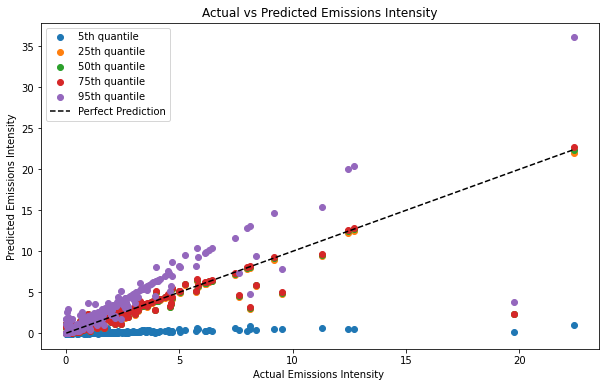

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions[0.05], label="5th quantile")
plt.scatter(y_test, test_predictions[0.25], label="25th quantile")
plt.scatter(y_test, test_predictions[0.50], label="50th quantile")
plt.scatter(y_test, test_predictions[0.75], label="75th quantile")
plt.scatter(y_test, test_predictions[0.95], label="95th quantile")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color = 'black', linestyle='--', label="Perfect Prediction")
plt.xlabel('Actual Emissions Intensity ')
plt.ylabel('Predicted Emissions Intensity')
plt.title('Actual vs Predicted Emissions Intensity')
plt.legend()

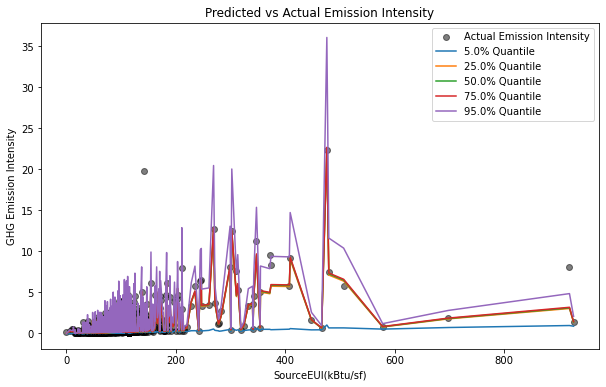

In [27]:
source_eui_test = X_test['SourceEUI(kBtu/sf)']
sort = np.argsort(source_eui_test)
sorted_source_eui = source_eui_test.iloc[sort]
sorted_predictions = {quantile: np.array(test_predictions[quantile])[sort] for quantile in quantiles}

plt.figure(figsize=(10, 6))
plt.scatter(source_eui_test, y_test, color='black', alpha=0.5, label="Actual Emission Intensity")
for quantile in quantiles:
    plt.plot(sorted_source_eui, sorted_predictions[quantile], label=f"{quantile*100}% Quantile")
plt.xlabel('SourceEUI(kBtu/sf)')
plt.ylabel('GHG Emission Intensity')
plt.title('Predicted vs Actual Emission Intensity')
plt.legend()
plt.show()

Overall, the model performs fairly well, with the 0.5 quantile being the best performing, in terms of mean pinball loss. This is very good for the model, as this means it is best at capturing the central tendency of the data. In this sense, the model is a good option for our goal of being able to predict the emission intensity of a building. On the otherhand, the two tail quantiles, 0.05 and 0.95, perform much worse than the others, and aren't very strong estimations. While as I mentioned earlier this can be partially explained by the existence of outliers and the nature of the penalization that pinball loss uses, it is also an indicator that the regression is quite limited when it comes to capturing the very low and high values. As one of the goals of our project was to learn what can be done to minimize a buildings emission intensity, this is alarming. If we can't capture these values well, it means the model doesn't provide a good explanation for the uniquely great and poor buildings, which are the exact buildings we would want to focus on, as implementing commonalities amongst the buildings with low emissions and avoiding the commonalities of the buildings with high emissions is how we can detect the factors that make a building good at handling emissions. Due to this, it would be beneficial to look into other models that can better predict these important tail values, while maintaining a good level of accuracy at predicting the central values.